# NVIDIA Project: Short-Term Predictability of NVIDIA Stock Returns in the AI Era
## Callum McIntyre 

In recent years, artificial intelligence has become one of the largest growing industries in the global economy, with many of the biggest companies investing billions of dollars into their own AI models, infrastructures, and applications. At the forefront of this movement is NVIDIA, who are developing their own AI models and systems as well as creating the hardware to support AI model deployment for every other AI model on the market. As a result, NVIDIA, who previously only developed GPUs and other computer hardware, has recently seen their stock skyrocket with the demand for their AI applications and advanced AI centric hardware.

This rapid, AI-driven increase in market valuation raises an important question for financial economists and investors. With NVIDIA now being one of the most valuable and popular stocks on the market due to this AI boom, market activity surronding the firm has increased significantly. Motivated by this context, this project seeks to examine whether NVIDIA's prominence in the AI industry has affected the short-term predictability of its stock returns. While we reasonably expect NVIDIA’s stock to perform positively over the long term given its industry position, this project focuses on whether AI influenced short-term fluctuations can be accurately anticipated, which is crucial for active trading and risk management strategies. Specifically, the research question this project aims to address is:

### Does NVIDIA’s AI-driven acceleration impact the short term predictability of its stock returns?



Moving forward with our analysis, we will import all of the necessary libraries and packages required for data collection, manipulation, and analysis.

In [1]:
# import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import jarque_bera
import warnings
warnings.filterwarnings("ignore")


Next we will collect our data on NVIDIA's stock price by utilizing the yfinance package to pull historical stock price data from Yahoo Finance. We will focus on daily closing prices ranging from January 1, 2016 to December 1, 2025 to capture both pre-AI boom and post-AI boom periods for comparison and full view of stock performance.

#### Data Collection

In [2]:
# download NVIDIA daily data from Yahoo Finance
ticker = "NVDA"
start = "2016-01-01"
end = "2025-12-01"

# request daily data
nvidia_data = yf.download(ticker, start=start, end=end, progress=False)

# prepare the data
nvidia_data = nvidia_data[['Close']].dropna()
nvidia_data.rename(columns={'Close': 'price'}, inplace=True)
nvidia_data.index.name = 'date'

#print basic info about the data
print(nvidia_data.shape)
print(nvidia_data.head())
print(nvidia_data.tail())

(2492, 1)
Price          price
Ticker          NVDA
date                
2016-01-04  0.789588
2016-01-05  0.802272
2016-01-06  0.769098
2016-01-07  0.738607
2016-01-08  0.722752
Price            price
Ticker            NVDA
date                  
2025-11-21  178.870041
2025-11-24  182.539841
2025-11-25  177.810104
2025-11-26  180.249954
2025-11-28  176.990143


We can see her that we have successfully imported the data and have a dataframe with the dates from beginning of 2016 to the start of December 2025.

In order to get a better view of our data for economic analysis, we will print out a graph of the NVIDIA closing prices.


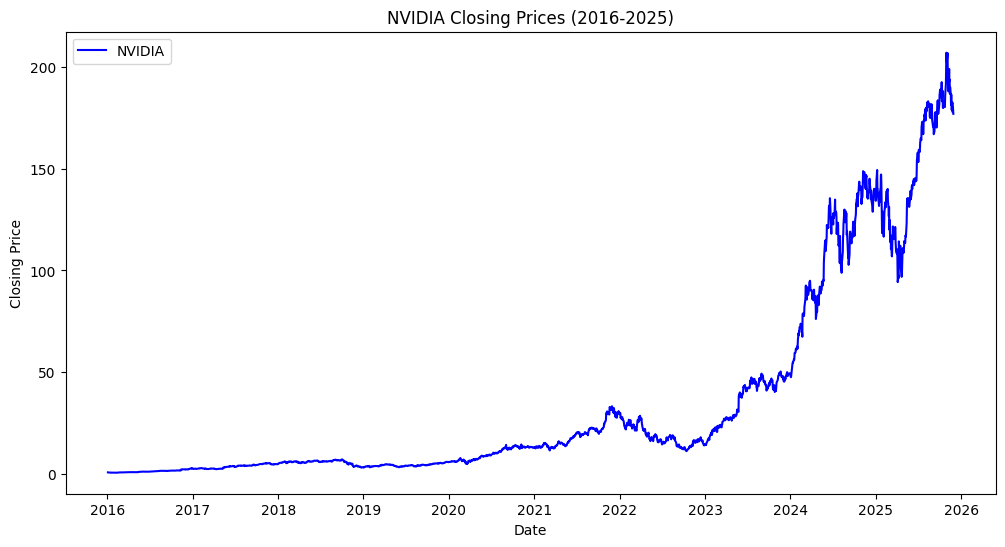

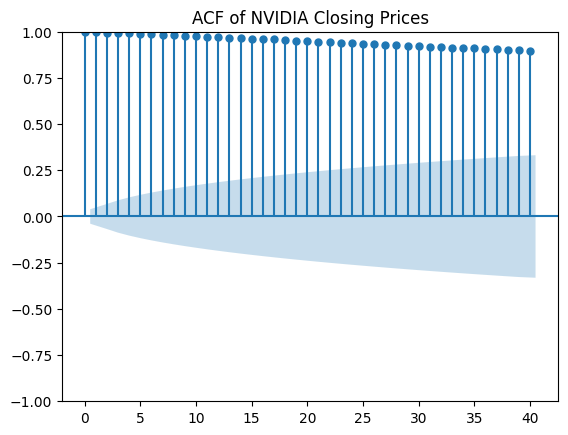

In [3]:
# plot nvidia_data closing prices
plt.figure(figsize=(12, 6))
plt.plot(nvidia_data.index, nvidia_data['price'], label='NVIDIA', color='blue')
plt.title('NVIDIA Closing Prices (2016-2025)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# plot ACF of nvidia_data closing prices
plot_acf(nvidia_data['price'], lags=40)
plt.title('ACF of NVIDIA Closing Prices')
plt.show()

The top graph shows the daily closing prices of NVIDIA stock from January 2016 to December 2025. We can now visually see the high positive trend in stock prices, especially starting around late 2023, which corresponds with the AI boom period.

The bottom graph displays the ACF of the NVIDIA closing prices which measures the correlation from one time period to another. We plot this ACF graph to see if our stock prices are stationary or not. We know a time series is stationary if the ACF plot decays very fast as the lag increases. Here we can see that our ACF of the NVIDIA stock price decays very slowly, which indicates that the stock price series is non-stationary. This is very common for stock prices, as they tend to follow a random walk.

Since we have established that the NVIDIA stock price series is non-stationary, we will now transform the data into a stationary series by calculating its daily log returns. We will do this by taking the natural logarithm of the ratio of consecutive closing prices and then computing the first different of the log prices. This transformation will allow us to analyze the short-term predictability of NVIDIA's stock returns more effectively.

We will then print out a plot of the daily log returns to visualize the transformed data and print out the ACF of the log returns to check for stationarity.

#### Calculating Log Returns

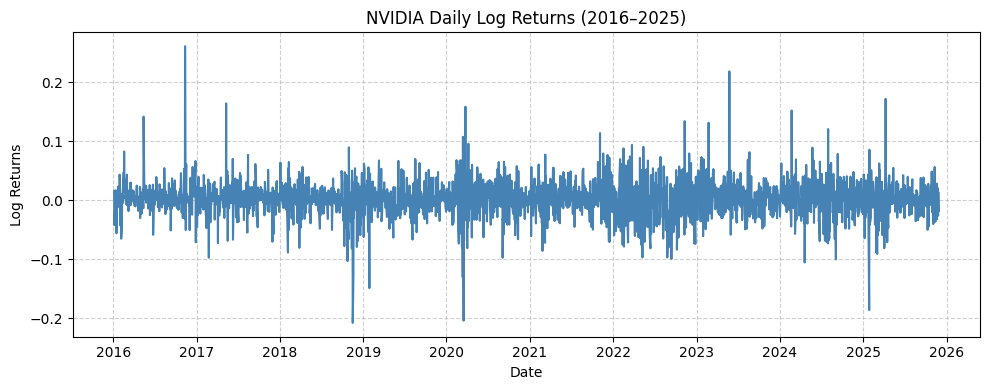

<Figure size 1000x500 with 0 Axes>

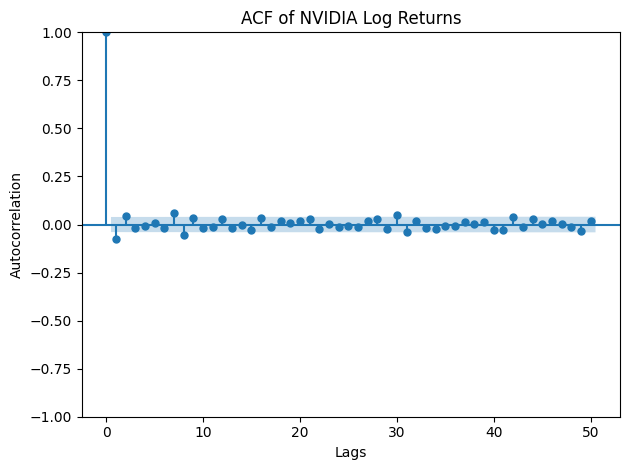

In [4]:
# compute log of prices
nvidia_data['log_price'] = np.log(nvidia_data['price'])

# compute daily log first differences (log returns)
nvidia_data['log_price_returns'] = nvidia_data['log_price'].diff()   # log returns
nvidia_data = nvidia_data.dropna()

# plot log price returns
plt.figure(figsize=(10, 4))
plt.plot(nvidia_data.index, nvidia_data['log_price_returns'], color='steelblue')
plt.title('NVIDIA Daily Log Returns (2016–2025)')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# plot ACF of log-differenced series
plt.figure(figsize=(10, 5))
plot_acf(nvidia_data['log_price_returns'], lags=50)
plt.title("ACF of NVIDIA Log Returns")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

#### Observing Log Returns and Stationarity

We now see that the ACF of the NVIDIA log returns decays very quickly, indicating that the log return series is stationary. Another requirement for a series to be stationary is that it does not show a time trend or seasonality, which we can also observe from the log returns plot. With this confirmation that we are now working with a stationary series, we can proceed with our analysis.

Next we will perform a Ljung-Box test on our NVIDIA log returns data to test if our series is white noise or not. The null hypothesis of the Ljung-Box test is that there is no significant autocorrelation in the series and the series is white noise. If we reject the null hypothesis, it suggests that there is some level of predictability in the log returns and the series is not white noise.

#### Checking if Log Returns are White Noise

In [5]:
# Ljung-Box test (multiple lags)
ljung_box_results = acorr_ljungbox(nvidia_data['log_price_returns'], lags=[10, 20, 30], return_df=True)
print("Ljung-Box test (returns):\n", ljung_box_results)

Ljung-Box test (returns):
       lb_stat  lb_pvalue
10  40.905795   0.000012
20  51.952595   0.000116
30  68.478306   0.000077


We can see that the p-values for the Ljung-Box test are all very small and statisically significant (less then 0.05) so we can reject the null hypothesis and conclude that this series is NOT white noise. With this information, we can now model the NVIDIA stock because there is some level of predictability in the log returns. If we had failed to reject the null hypothesis, it would suggest that the log returns are random and unpredictable, like a white noise series would be, which would make modeling and forecasting impossible. 

Next we will use the pmdarima package's auto_arima function to find the best fitting ARMA(p,q) model for our NVIDIA log returns data based on the AIC. The auto_arima function will automatically search through different combinations of AR and MA orders to find the model that minimizes the AIC value, which helps us select a model that balances goodness of fit and model complexity.

We will feed in the log_price series and set the differencing order to 1.

#### Model Selection with Auto ARIMA

In [6]:
import pmdarima as pm

# auto arima to find best ARMA(p,q) model based on AIC
auto_model = pm.auto_arima(
    nvidia_data['log_price'],
    start_p=0, max_p=6,          # range for AR order (up to 10, inclusive of p=0)
    start_q=0, max_q=6,          # range for MA order (up to 10, inclusive of q=0)
    d=1,                         # differencing order is 1
    seasonal=False,              # non-seasonal model
    information_criterion='aic', # minimize AIC, couldve used 'bic' as well
    stepwise=True,               # use fast stepwise search
    trace=True,                  # prints progress
    error_action='ignore',       # skip non-converging models
    suppress_warnings=True
)

# best model summary
print("\nBest ARMA model found (Minimizing AIC):")
print(auto_model.summary())

# printing the best model order
best_model = auto_model.order
print(f"\nOptimal order (p,d,q) found by pmdarima: {best_model}")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10177.595, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10190.143, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10189.068, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10167.703, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-10191.760, Time=0.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-10190.033, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10189.839, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10190.903, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-10188.059, Time=2.13 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-10181.053, Time=0.62 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 6.103 seconds

Best ARMA model found (Minimizing AIC):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2491
M

After running the model selection, we find that the best fitting model is (2,1,0) which indicates that an AR(2) model with first differencing (d=1) provides the best fit for the NVIDIA log returns data according to the AIC criterion. This suggests that the current log return can be effectively modeled using its two previous values. We see that the AR(1) coefficient value is -0.0742 which indicates a slight negative relationship with the first lagged return, while the AR(2) coefficient value is 0.0381 which indicates a moderate positive relationship with the second lagged return. Both coefficients are statistically significant as their p-values are less than 0.05. Combined, these coefficients suggest that the NVIDIA log returns exhibit some level of short-term dependence, which can be captured by this AR(2) model. Although there is some level of predictability in the returns, the relatively small magnitude of the coefficients also indicates that the returns are still quite volatile and influenced by other factors.

We will now investigate the residuals of our selected model to ensure that they behave like white noise. This is an important step to validate our model, as it indicates that the model has successfully captured all the underlying patterns in the data, and nothing is up to random white noise.

#### Diagnostic Checks on Residuals

<Figure size 800x400 with 0 Axes>

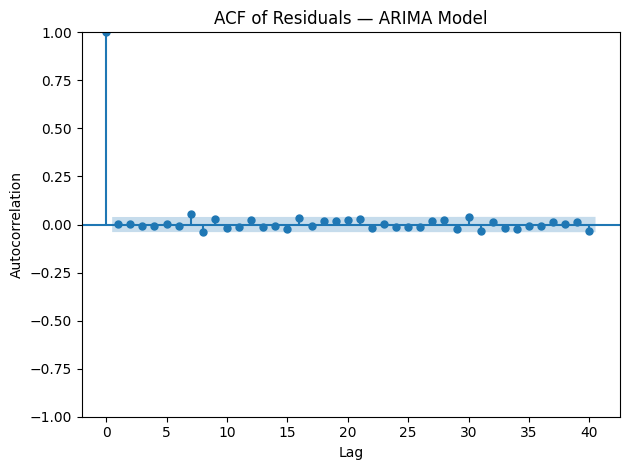


Ljung–Box Test for Residual Autocorrelation:
      lb_stat  lb_pvalue
10  14.525643   0.150337
20  24.560980   0.218746
40  44.088119   0.302797


In [7]:
# get residuals from the fitted model
residuals = auto_model.resid()

# plot ACF of residuals
plt.figure(figsize=(8, 4))
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals — ARIMA Model")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

# Ljung-Box test on residuals
ljung_box = acorr_ljungbox(residuals, lags=[10, 20, 40], return_df=True)

# print Ljung-Box test results
print("\nLjung–Box Test for Residual Autocorrelation:")
print(ljung_box)


Here we see the Ljung–Box test applied to the ARIMA residuals fails to reject the null hypothesis of no serial correlation at conventional significance levels. This suggests that the ARIMA model adequately captures the conditional mean dynamics of NVIDIA’s returns, and the residuals behave approximately as white noise in the mean. This is an important, desired property for a well-specified time series model because it indicates that there are no remaining predictable patterns in the residuals that the model has failed to capture.

Next we will check for ARCH/GARCH effects, which indicate volatility clustering, in the residuals by again performing a Ljung-Box test, but this time on the squared residuals.

<Figure size 800x400 with 0 Axes>

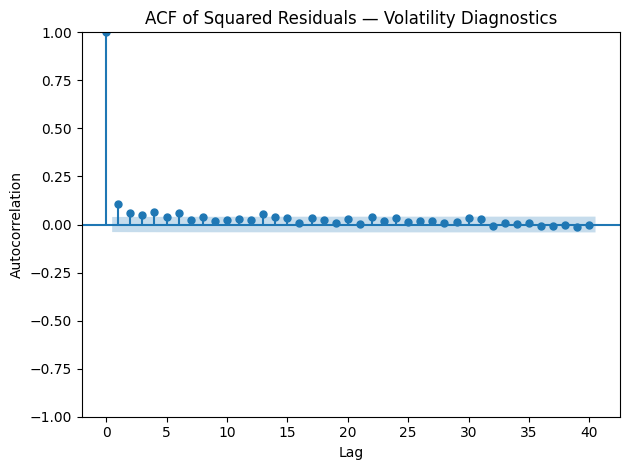


Ljung–Box Test on Squared Residuals (ARCH/GARCH Effects):
       lb_stat     lb_pvalue
10   74.776497  5.258956e-12
20   99.950467  1.285581e-12
40  118.143418  1.203272e-09


In [8]:
# Squared residuals
squared_residuals = residuals**2

# ACF of squared residuals
plt.figure(figsize=(8, 4))
plot_acf(squared_residuals, lags=40)
plt.title("ACF of Squared Residuals — Volatility Diagnostics")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

# Ljung–Box test on squared residuals
ljung_box_sq = acorr_ljungbox( squared_residuals, lags=[10, 20, 40], return_df=True)

print("\nLjung–Box Test on Squared Residuals (ARCH/GARCH Effects):")
print(ljung_box_sq)


We apply the Ljung–Box test to the squared residuals and it strongly rejects the null hypothesis of no autocorrelation, providing evidence of conditional heteroskedasticity. This is a common feature in financial return series, where periods of high volatility tend to be followed by more high volatility, and periods of low volatility tend to be followed by more low volatility. This indicates the presence of volatility clustering in NVIDIA’s returns and motivates the use of a GARCH model to capture time-varying volatility. Our ARMA model only captures the conditional mean, so incorporating a GARCH component will help indentify the volatility dynamics that the ARMA model alone cannot address. GARCH would effectively handle and model the changing variance over time, which is crucial for accurate risk assessment and forecasting in financial markets.






Now I will plot the fitted prices from our ARIMA model against the actual log returns for a quick visual assessment of the model's performance. 

#### Plotting Fitted vs Actual Values

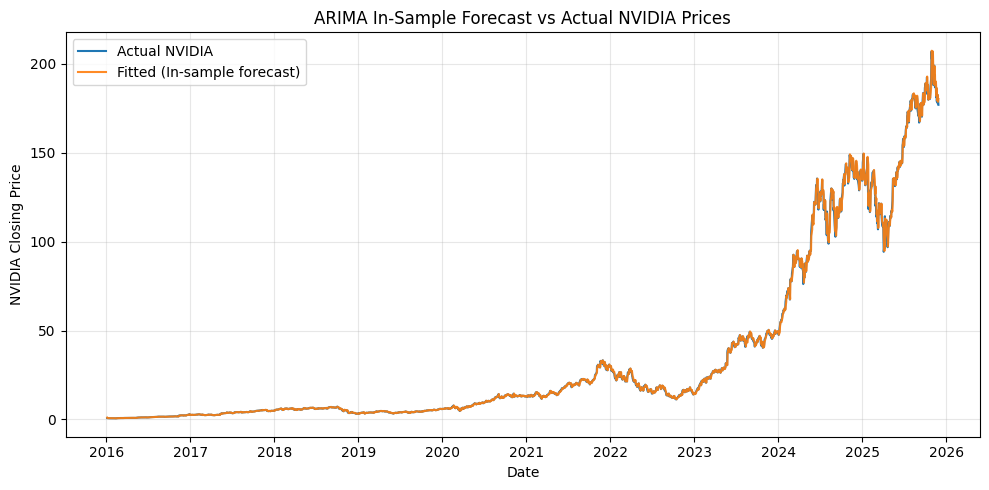

In [9]:
# get fitted values (these are log prices)
fitted_log_prices = auto_model.predict_in_sample()

# transform fitted log prices back to actual prices
fitted_prices = np.exp(fitted_log_prices)

# getting fitted series by aligning index
fitted_series = pd.Series(fitted_prices, index=nvidia_data.index).astype(float)

# create actual series aligned to the fitted series index
actual_series = nvidia_data['price'].reindex(fitted_series.index).astype(float)

# plot actual vs fitted 
plt.figure(figsize=(10,5))
plt.plot(actual_series.index, actual_series.values, label="Actual NVIDIA", linewidth=1.5)
plt.plot(fitted_series.index, fitted_series.values, label="Fitted (In-sample forecast)", linewidth=1.5, alpha=0.9)
plt.title("ARIMA In-Sample Forecast vs Actual NVIDIA Prices")
plt.xlabel("Date")
plt.ylabel("NVIDIA Closing Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



We can see here that the fitted values closely follow to actual price movements, which is expected as the ARIMA model uses returns to fit the data, so the fitted values will naturally align with the actual price series. While this visual allignment is encouraging, it is important to interpret it cautiously as this graph only shows how the model can reproduce the overall trend in prices due to the accumulation of returns. We will need to further investigate the model's out of sample forecasting performance to truly assess its predictive power.

To investigate this, we will forecast the next 10 days of NVIDIA stock prices and use the auto_model.predict() function. We will plot our forecasted prices along with 95% confidence intervals to be able to visualize the forecast.

#### Forecasting NVIDIA Stock Prices for the Next 10 Days

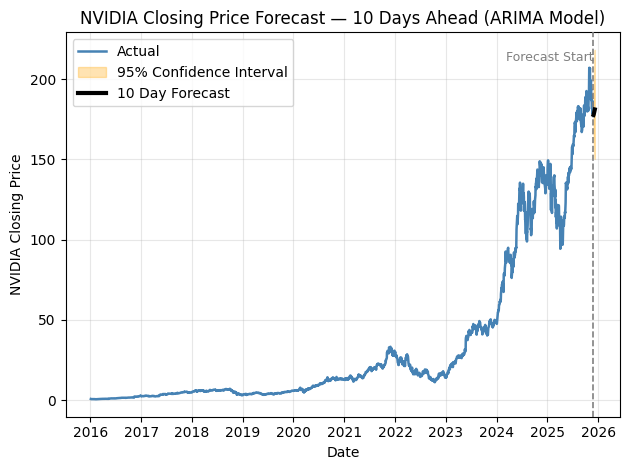

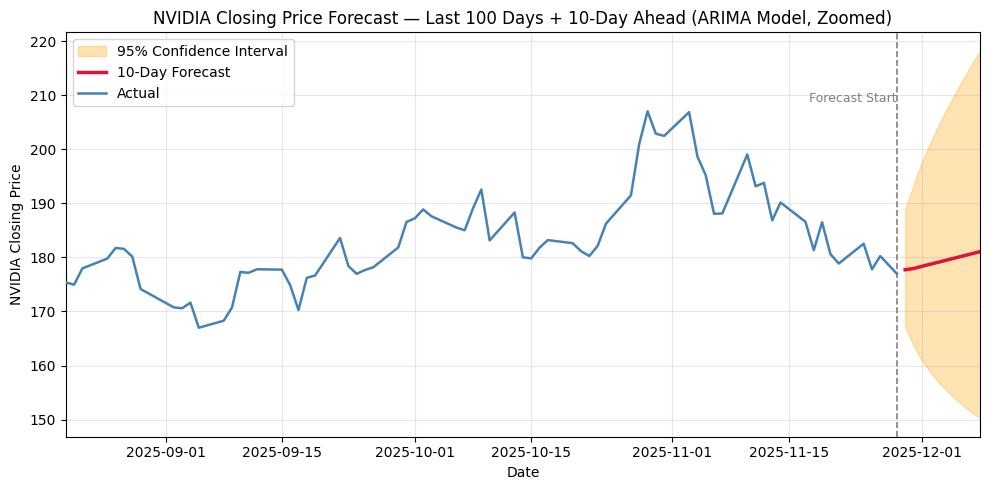


Forecasted closing price after 10 days: $181.07
Initial closing price: $176.99
Forecasted increase after 10 days: $4.08 (2.31%)


In [10]:
# number of forecast periods
n_periods = 10

# forecast future log prices and 95% confidence intervals
forecast_log, conf_int_log = auto_model.predict(n_periods=n_periods, return_conf_int=True, alpha=0.05)

# transform log forecasts and intervals to actual prices
forecast = np.exp(forecast_log)
conf_int = np.exp(conf_int_log)

# build future date index for daily frequency
last_date = actual_series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_periods, freq='D')

# plot actual data
plt.plot(actual_series, label="Actual", linewidth=1.8, color='steelblue', zorder=2)

# plot the confidence interval shading
plt.fill_between(
    future_dates,
    conf_int[:, 0],
    conf_int[:, 1],
    color='orange',
    alpha=0.3,
    label='95% Confidence Interval',
    zorder=1
)

# plot forecasted values
plt.plot(future_dates, forecast, color='black', linewidth=3, label="10 Day Forecast", zorder=5)

# plot vertical line to mark forecast start
plt.axvline(actual_series.index[-1], color='gray', linestyle='--', linewidth=1.2, zorder=3)
plt.text(actual_series.index[-1], plt.ylim()[1]*0.95, 'Forecast Start',
         ha='right', va='top', color='gray', fontsize=9)

# formatting the plot
plt.title("NVIDIA Closing Price Forecast — 10 Days Ahead (ARIMA Model)")
plt.xlabel("Date")
plt.ylabel("NVIDIA Closing Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Zoomed plot: last 100 days plus forecast ---

plt.figure(figsize=(10,5))

# plot confidence interval shading
plt.fill_between(
    future_dates,
    conf_int[:, 0],
    conf_int[:, 1],
    color='orange',
    alpha=0.3,
    label='95% Confidence Interval',
    zorder=1
)

# plot forecasted values
plt.plot(future_dates, forecast, color='crimson', linewidth=2.5,
         label=f"{n_periods}-Day Forecast", zorder=2)

# plot vertical line to mark forecast start
plt.axvline(last_date, color='gray', linestyle='--', linewidth=1.2, zorder=3)
plt.text(last_date, plt.ylim()[1]*0.95, 'Forecast Start',
         ha='right', va='top', color='gray', fontsize=9)

# plot actual data from last 100 days for context
plt.plot(actual_series.loc[last_date - pd.Timedelta(days=100):],
         label="Actual", linewidth=1.8, color='steelblue', zorder=4)

# formatting the plot
plt.title(f"NVIDIA Closing Price Forecast — Last 100 Days + {n_periods}-Day Ahead (ARIMA Model, Zoomed)")
plt.xlabel("Date")
plt.ylabel("NVIDIA Closing Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# zoom into last 100 days plus forecast period to see the forecast clearly
plt.xlim([last_date - pd.Timedelta(days=100), future_dates[-1]])
plt.show()

# calculate forecasted increase and percentage increase
initial_price = float(nvidia_data['price'].iloc[-1])
final_forecast_price = forecast.values[-1]
forecasted_increase = final_forecast_price - initial_price
percent_increase = (forecasted_increase / initial_price) * 100

# print forecasted increase and percentage increase
print(f"\nForecasted closing price after 10 days: ${final_forecast_price:,.2f}")
print(f"Initial closing price: ${initial_price:,.2f}")
print(f"Forecasted increase after 10 days: ${forecasted_increase:,.2f} ({percent_increase:.2f}%)")

Numerically examining our results, the last observed price as of December 1, 2025, which is $176.99, and our forecasted price for December 11, 2025, which is $181.07. This represents an expected increase of approximately 2.31% over the 10-day forecast horizon, suggesting a modest upward movement in NVIDIA's stock price according to our ARIMA model. 

In the first plot, we see the NVIDIA stock prices, as well as our small forecast for the next 10 days, and then in our second plot we have a zoomed in version of our forecasted prices with the 95% confidence intervals shown in yellow and the 10 day forecast shown in red. The model predicts a consistent upward trend in NVIDIA's stock prices over the next 10 days, which aligns with the overall positive momentum observed in the historical data. The large confidence intervals provide a range of potential outcomes, which reflects the inherent uncertainty in stock price predictions. The confidence interval widens as we move further into the forecast period, which is expected from a time series forecast as uncertainty increases with time.

A very important observation from our forecast is that the forecasted values for the next 10 days form a nearly straight line. This flattening is commonly seen in ARIMA models when the model captures the long-run trend of the data rather then capturing the short-term fluctuations of our NVIDIA stock. There is a stark difference in the shape of the values before our forecast period and during our forecast period. Before the forecast period, the closing prices show a lot of variation and fluctuations, while our 10 day forecast shows very little movement and is almost a straight line. The model does a good job of showing a general direction of the stock price but it is unable to capture the short-term ups and downs of the stock price. This is a limitation of our ARIMA model and suggests that it can predict a general trend it is unable to capture a realistic 10 day forecast.

### Conclusions

To summarize our findings, we first imported NVIDIA's stock price data from Yahoo Finance from January 2016 to December 2025. After importing the data, we observed that the stock price series was non-stationary through ACF analysis. To address this, we calculated the daily log returns to transform the non-stationary price series into a stationary series suitable for time series modeling. We confirmed the stationarity of the log returns through ACF analysis and visual inspection.

After confirming stationarity, we performed a Ljung-Box test which indicated that the log returns were not white noise, suggesting some level of predictability. After that critical step, we then used the auto_arima function to identify the best fitting ARIMA model, which was determined to be ARIMA(2,1,0). Diagnostic checks on the model residuals confirmed that they behaved like white noise in the mean, but exhibited GARCH effects, indicating volatility clustering.

Finally, we used our ARIMA model to forecast NVIDIA's stock prices for the next 10 days, predicting a modest increase in price. Revisiting our research question of "Does the upward, AI-driven revaluation of NVIDIA translate into short-term predictability of its stock returns?", we can conclude that based on our analysis, there is evidence to suggest that NVIDIA's stock returns do not exhibit short-term predictability after the large market movements and activity driven by AI developments. 

Throughout our examination, we found that NVIDIA's price appreciation and movement are unpredictable in the short term. Our analysis depicts that there is a small level of predictability in the returns. The short term 10 day forecast only indicates a more general trend that could be applied to a long term forecast rather then successfully predicting short term price movements. The direction and magnitude of a highly traded stock in a rapidly evolving industry like NVIDIA is influenced by a multitude of different factors, such as market sentiment, macroeconomic news and industry developments, which are inherently difficult to predict in the short term and are not captured by our ARIMA model. The model identifies the assumed long term upward trend in prices, the forecasted values lack of day to day variation and widening confidence intervals reflect that the model is unable to capture the short term fluctuations in prices. These short term fluctuations in prices are what traders and investors are most interested in predicting in the short term, and our model fails to provide that level of predictability. Therefore, while NVIDIA's trends can be observed over longer time frames, our model does not provide the reliable short term predictability needed to capitalize on the stock's AI driven changes. Implications of our findings suggest that investors and traders should be cautious when attempting to make decisions based on short term forecast of NVIDIA as the stock's returns appear largely unpredictable in the short term, which likely comes as a result of the company's significant AI-driven growth and involvement.